# Weighted mask cross-correlation

## Why a weighted mask?

We have seen (or we will see!) the power of the likelihood frameworks developed by Brogi & Line (2019), Gibson et al. (2020). They provide the highest constraining power and can get precise confidence intervals for atmospheric parameters. So why even bothering with alternative methods?

I see two reasons why you should consider a weighted mask (sometimes called "binary") approach.
1. It is the most **model independent** method I am aware of to detect a molecule/atom;
2. It allows you to visualize what you are fitting.

It is possible to perform a statistically sound fit also with the binary mask method (Pino et al., 2020). It seems to deliver a lower precision on model parameters. However, this is an avenue that I have not fully explored and that could provide complementary information to the cross-correlation-likelihood mapping methods.

## What is a weighted binary mask?

A set of apertures that collect all the flux that falls within them, and exclude everything outside of them. We may want to give weights that account for the amount of "information" in each aperture.

The only input information we need is the position of the lines we want to include in the mask (which we can get from line lists such as VALD, ExoMOL, ...), and, if we want, a set of weights. As you can see, these are only a subset of the information that we need to include in an atmospheric model that we use for cross-correlating. In this sense, this approach is less model dependent (if you use weight, it still is).

<img src="Binary_mask.gif" width="750" align="center">

This is also called "stacking", and is a method used in extragalctic studies to stack faint lines from many different galaxies to build up SNR. Here, we cumulate many lines belonging to the same species, but on a single planet. As an example, here is a model (in red) of a water + clouds transmission spectrum of HD189733b, and in black is the "noisy" version where I have added simulated ESPRESSO white noise corresponding to one single transit of the planet.

<img src=" Noisy_model.png" width="750" align="center">

Now, we apply the binary mask stacking on a specific water band, by taking from the strongest to the weakest line. With 100 - 1000 lines, we get a strong and clear detection (of course, this is a somewhat ideal case. This only works with **white noise**.

<table><tr>
<td> <img src="Binary_mask_application_simulated_data.gif" width="500" align="left">
<td> <img src="Binary_mask_application_simulated_data_2.gif" width="500" align="right">
</tr></table>

You can have different kinds of masks, including specific to search some atoms or molecules or built starting from stellar data. David will cover more of the binary mask concept later.

Now, I give you my implementation of this concept.

## Weighted mask implementation

### Definitions, and preparing the ESPRESSO pipeline weighted mask

The mask has the form of a list of wavelengths and the corresponding weights. There are two additional "meta-parameters" that we need to decide on, but we have good arguments for their choice and in my opinion they do not introduce additional model dependence.
1. Every individual aperture has a size in wavelength (or better radial velocity) which we need to specify. This controls the amount of flux that is collected in that aperture;
2. We do not know in advance the position of the rest frame of the exoplanet atmosphere signal. Thus, we will need to slide the mask on the spectrum, to identify that. We will do this in velocity space, and we need to decide on which grid.
To determine the best values for these parameters, we need to be familiar with the difference between "resolving power" and "resolution". Note that in the literature there is often some confusion on these terms. I believe that this is the correct nomenclature from the spectroscopy community, but you may often find that the terms are used interchangeably. Always take care on what is meant precisely! Here are my definitions.

*Resolving power*: c/FWHM_LSF [km/s]. This controls the size of the LSF, and thus determines how far can two spectrscopic lines be in order for us to resolve them, and be able to individually characterize them.
*Resolution*: c/pixel_size [km/s]. This controls the size of a single pixel. Why is it different compared to the resolving power? For instruments like ESPRESSO, we aim to a precision in RV which is much much higher compared to the resolving power. We achieve that with several tricks which rely on the stability of the instrument, i.e., the LSF does not chang in time during the night. We want to be able to monitor this, and to know the shape of the LSF very precisely. Thus, we oversample it with several pixels.

For ESPRESSO, we see that R = 140.000 is the resolving power. It corresponds to 2.14 km/s. The LSF is oversample 4.5 times, so the individual pixel size is 0.475 km/s.

**Aperture**: The optimal choice collects the largest amount of flux from photons which are independent from each other (to avoid having correlations). Thus, the unit to which we need to compare is the resolution. We chose each aperture to be exactly 0.475 km/s wide. A larger aperture will result in unnecesssary correlation. A smaller aperture will result in the loss of some flux, and thus higher photon noise.

**RV grid**: How far do we go? We need to have an idea of the maximum orbital speed of the planet. We can get that from the period and semi-major axis of the planet. For WASP-7b:

$K_\mathrm{p} = 2\pi a/P \sim 200 \mathrm{km\ s^{-1}}$

Step size: This is not crucial at this point, but if we want to perform a fit on this weighted binary mask (see Pino et al., 2020), we want every point to be statistically independent. The safe choice is to make sure that each point comes from an individually resolved spectral line, i.e. we step by one resolving power element (you probably could do a bit better, but careful with correlations!). Here, I put a smaller step just to show you a well sampled CCF, but consider that there may be some correlation between neighboring points in the end.

In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib
from astropy import visualization

aperture_width = 0.4759
RV_table = np.arange(-210., 210., 0.5)

Let's first load the final products of our previous pipeline.

In [5]:
# Here is where we were at.

S2D_wavelengths_vacuum_laboratory = np.load('S2D_wavelengths_vacuum_laboratory.npy')
S2D_spectra_stellar_rest_frame_normalized = np.load('S2D_spectra_stellar_rest_frame_with_star_included.npy')

# (exposures, orders, pixels)
np.shape(S2D_wavelengths_vacuum_laboratory)

(70, 170, 9111)

The mask is independent of exposure (lines are always the same), but we will have to build a separate mask for every order. Thus, the shape of our mask will be (n_lines, n_RV_points, n_orders). Since n_lines differs from order to order, this is no numpy array.

To start with, we will use the masks providede by the ESPRESSO pipeline (when you install it). Let's read one of them.

In [6]:
binary_mask_directory = '/data2/pino/Data/binary_masks/'
name = 'G2' # Try also: F9, G8, G9, K2, K6, M0, M2, M3, M4, M5

mask_file = fits.open(binary_mask_directory + 'ESPRESSO_pipeline/' + 'ESPRESSO_{}.fits'.format(name))

mask_wavelengths_air = mask_file[1].data['lambda'] # Wavelengths are provided in air.
mask_line_contrast = mask_file[1].data['contrast'] # Built on an observed template stellar spectum

print(np.shape(mask_wavelengths_air))
print(np.shape(mask_line_contrast))

(5484,)
(5484,)


This is 1D a list of wavelengths and weights. It is the input we need, but we need to rearrange it to apply it to the S2D spectra we have. First, let's convert the wavelengths to vacuum, where the observed spectra are given.

In [7]:
def n_air(mask_wavelengths_air):
    t=15. 
    p=760.
    
    # wavelength in A, t=temperature in C, p=pression in millibar
    n_air = 1e-6 * p * (1 + (1.049-0.0157*t)*1e-6*p) / 720.883 / (1 + 0.003661*t) * (64.328 + 29498.1/(146-(1e3/mask_wavelengths_air/10.)**2) + 255.4/(41-(1e3/mask_wavelengths_air/10.)**2))
    return n_air + 1

mask_wavelengths_vac = mask_wavelengths_air * n_air(mask_wavelengths_air)

We now rearrange by selecting only wavelengths that are fully contained in each order for all RV_shifts that we consider. We do not want lines to be only present in a subset of exposures, otherwise we would combine different information across exposures. You could in principle improve the SNR by taking all lines, but then you should be careful with the interpretation of your operations.

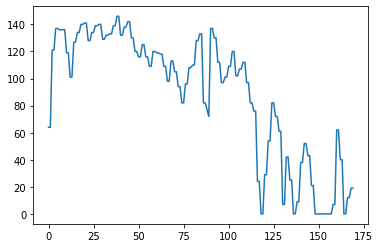

In [8]:
# To account for the fact that the blue CCD has less useful pixels, let's put nan in place of the wavelength value in the parts of the CCD we do not want to include.
# Since the wavelength array is in common across spectra, we only build this for S2D_wavelengths_vacuum_laboratory[0] 
wave_appo = np.where(S2D_spectra_stellar_rest_frame_normalized[0]==0, np.nan, S2D_wavelengths_vacuum_laboratory[0])
wave_min = np.nanmin(wave_appo, axis=1) # One for each order. Shape: (n_exposures, n_pixels)
wave_max = np.nanmax(wave_appo, axis=1)

# The bluest Doppler shift is given by the minimum RV considered in our mask, while the maximum Doppler shift is given by the maximum one.
# This function thus searches for the position of wave_min and wave_max inside the 1D mask provided by the ESPRESSO pipeline.
indexes_start_order = np.searchsorted(mask_wavelengths_vac, wave_min*(1.-RV_table[0]/2.99792458e5)+wave_min*aperture_width/2./2.99792458e5)
indexes_end_order = np.searchsorted(mask_wavelengths_vac, wave_max*(1.-RV_table[-1]/2.99792458e5)-wave_max*aperture_width/2./2.99792458e5)

mask_wavelengths_vac_S2D = []
mask_line_contrast_S2D = []

# We use the indexes to build the 2D mask.
for n, (i, j) in enumerate(zip(indexes_start_order, indexes_end_order)):
    mask_wavelengths_vac_S2D.append(mask_wavelengths_vac[i:j])
    mask_line_contrast_S2D.append(mask_line_contrast[i:j])
    
n_lines_per_order = []    
for order in range(len(mask_wavelengths_vac_S2D)):
    n_lines_per_order.append(len(mask_wavelengths_vac_S2D[order]))
    
plt.plot(n_lines_per_order)

### A practical way to make the computation faster

We follow Pino et al. (2020) Appendix B and, rather than cycling over the mask apertures, we build a weight for every pixel based on whether it falls within a mask or not. This is convenient for several reasons.
1. It allows matrix calculation that is much faster;
2. It allows us to store the mask for future use;
3. It makes it much simpler to implement other weights in our formalism (see later).

In this formalism, for every pixel we build the following weight:
$$w_\mathrm{pixel} = w_\mathrm{mask}\cdot\overline{\Delta \lambda}\ ,$$
where $w_\mathrm{mask}$ is the weight of the mask in that pixel (could be 0 if no aperture falls on that pixel), and $\overline{\Delta \lambda}$ could be the entire wavelength range spun by the pixel if it falls entirely in a mask, or the corresponding section.

<img src="Binary_mask_implementation.png" width="750" align="center">

In [9]:
def build_pixel_by_pixel_mask_single_order(l,mask_ll,mask_W,RV_table,bin_width):
    """Project a list of weights for a binary mask on a list of pixels. 

    Takes into account:
    - Non-constant pixel size in wavelength dimensions
    - Partial overlap between binary mask and pixel

    Input
    -------

    l: floats[n]
        List of central wavelengths of the pixels in the detector

    mask_ll, mask_W: floats[m]
        Lists containing:
        - The central wavelenghts of the lines in the binary mask
        - The weights corresponding to those lines

    RV_table: floats[n_rv]
        List containing the array of radial velocities over which the CCF will be computed.
        Every time we shift the binary mask, a new set of weights needs to be computed.

    bin_width: float
        - Size of the binary mask windows in units of km s-1



    Returns
    -------
    
    weights_pixels: floats[n_rv, n]
        Weights to be attributed to single pixels

    Notes
    -----

    Below you find a version of the routine that computes weights as mask_weight/\overbar{delta_lambda}_n (notation Pino et al. 2019).

    """



    # Compute mask width in wavelength units, accounting for shift
    mask_ll_shift = np.outer(mask_ll,(1.+RV_table/2.99792458e5))
    mask_width = mask_ll_shift*bin_width/2.99792458e5


    #
    # Preparation, everything in matrix form
    #

    # wavelengths corresponding to the beginning and the ending of the mask bins.
    lstart = mask_ll_shift - mask_width/2.
    lstop = mask_ll_shift + mask_width/2.


    av_band = np.stack([lstart,lstop], axis=2)

    # Compute extrema of pixels in wavelength space

    wave_bins = [ [(l[i-1] + l[i])/2.,(l[i] + l[i+1])/2.] for i in range(1,len(l)-1)]
    wave_bins.insert(0, [l[0] - (l[1] - l[0])/2., l[0] + (l[1] - l[0])/2. ])
    wave_bins.append([l[-1] - (l[-1] - l[-2])/2., l[-1] + (l[-1] - l[-2])/2. ])
    wave_bins = np.array(wave_bins)
    
    # Indexes of pixels within which the binary mask starts and stops ([n_rv, m])
    i_start = np.searchsorted(wave_bins[:,1], av_band[:,:,0])
    i_end = np.searchsorted(wave_bins[:,1], av_band[:,:,1])

    # Create a mask that weights every pixel based on:
    # (1) How much of the pixel is illuminated;
    # (2) The weight of the binary mask

    # In each pixel, the weight is computed as mask_weight * \overbar{delta_lambda} (notation Pino et al. 2020), where \overbar{delta_lambda}_n can be:
    # - delta_lambda_n, i.e the full pixel. This is the first case below.
    # - Only a part of a pixel. The other if/else clauses deal with that
    weights_pixels = [] 
    for n_rv in range(len(i_start[1])):
        pixel_interm = []
        mask_pixel_single_rv = np.zeros(len(wave_bins))
        for m, (i_s, i_e) in enumerate(zip(i_start[:, n_rv], i_end[:,n_rv])):

            # Pixels fully contained within a binary mask aperture
            if any(range(i_s+1, i_e)):
                mask_pixel_single_rv[range(i_s+1, i_e)] = mask_W[m]*np.diff(wave_bins[range(i_s+1, i_e)], axis=1)[:,0]

            # The binary mask aperture is fully contained within a pixel
            if i_s == i_e:
                mask_pixel_single_rv[i_s] = mask_W[m]*np.diff(av_band[m, n_rv])

            # Binary mask partially covers the pixels found at the start and end
            else:
                mask_pixel_single_rv[i_s] = mask_W[m]*(wave_bins[i_s,1]-av_band[m, n_rv,0])
                mask_pixel_single_rv[i_e] = mask_W[m]*(av_band[m, n_rv,1] - wave_bins[i_e,0])              
        weights_pixels.append(mask_pixel_single_rv)
    weights_pixels = np.array(weights_pixels)

    return weights_pixels

In [26]:
# pixel_by_pixel_mask = np.zeros((len(S2D_wavelengths_vacuum_laboratory[0]), len(RV_table), len(S2D_wavelengths_vacuum_laboratory[0,0]))) # (n_orders, n_RVs, n_pizels)

# for order, (w, ww_ll, weights) in enumerate(zip(S2D_wavelengths_vacuum_laboratory[0], mask_wavelengths_vac_S2D, mask_line_contrast_S2D)):
#     print("Generating mask for order {}".format(order))
#     if any(weights != 0.): 
#         pixel_by_pixel_mask[order] = build_pixel_by_pixel_mask_single_order(w, ww_ll, weights, RV_table, aperture_width)
#     else: 
#         pixel_by_pixel_mask[order] = np.zeros( (len(RV_table), len(w)))

Generating mask for order 0
Generating mask for order 1
Generating mask for order 2
Generating mask for order 3
Generating mask for order 4
Generating mask for order 5
Generating mask for order 6
Generating mask for order 7
Generating mask for order 8
Generating mask for order 9
Generating mask for order 10
Generating mask for order 11
Generating mask for order 12
Generating mask for order 13
Generating mask for order 14
Generating mask for order 15
Generating mask for order 16
Generating mask for order 17
Generating mask for order 18
Generating mask for order 19
Generating mask for order 20
Generating mask for order 21
Generating mask for order 22
Generating mask for order 23
Generating mask for order 24
Generating mask for order 25
Generating mask for order 26
Generating mask for order 27
Generating mask for order 28
Generating mask for order 29
Generating mask for order 30
Generating mask for order 31
Generating mask for order 32
Generating mask for order 33
Generating mask for orde

In [27]:
# np.save('pixel_by_pixel_mask', pixel_by_pixel_mask)

In [10]:
pixel_by_pixel_mask = np.load('pixel_by_pixel_mask.npy')

(1000.0, 600000.0)

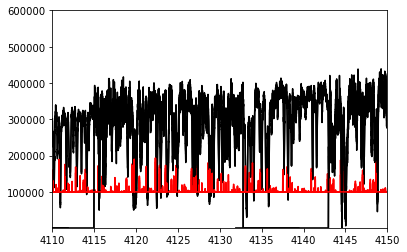

In [27]:
for w, s, m in zip(S2D_wavelengths_vacuum_laboratory[50], S2D_spectra_stellar_rest_frame_normalized[50], pixel_by_pixel_mask[:, 400]):
    plt.plot(w, s, 'k', w, 2.e7*(m)+1.e5, 'r')

plt.xlim(4110, 4150)
plt.ylim(1.e3, 6.e5)

We are now ready to calculate the cross-correlation as a simple matrix product! However, let's consider for a second if we are done or not. Let's have a look at the spectra again.

Clearly, if we simply apply the weighted mask, we will be dominated by the noise picked in the bad pixels. We thus apply two additional sets of weights:
1. We weight orders with respect to each other, so that orders with overall higher SNR are weighted more.
2. Within a single order, we need to downweight the borders where we receive very little flux (crucial in the blue CCD!)

### Weights on orders

We can use the signal-to-noise registered in each order that is found in the headers of the ESPRESSO. Note that, due to color effects, the relative weights of orders could change throughout the night and we need to account for that. So we calculate weights on an exposure-by-exposure basis.

In [31]:
def read_sorted_hdus(input_data_directory, data_type, target_name):
    
    # Get all data in folder of the specified type
    import glob
    data_files = np.array(glob.glob(input_data_directory + '*_{}_*'.format(data_type)))
    
    # Read date and time from the filename (standardized)
    date_time_observations = get_date_time_observations(data_files, data_type=data_type)
    
    # Sort exposures in time
    time_sorted_exposures_mask = compute_time_sorted_exposures_mask(date_time_observations)
    data_files_sorted = data_files[time_sorted_exposures_mask]

    # Open the fits and return them. Not the cheapest in terms of memory, but we'll use some of the info in the headers
    hdus = []
    for file_name in data_files_sorted:
        hdu = fits.open(file_name)
        if hdu[0].header['HIERARCH ESO OBS TARG NAME'] == target_name:
            hdus.append(hdu)    

    return hdus

def get_date_time_observations(data_files, data_type):
    """ Extract the date and time of an expsure from its name.
    """
    import re
    re.compile(data_type)

    date_time_observations = [] 

    for file in data_files:
        start = re.search(data_type + '_', file).end()

        date = file[start:start+10]
        time = file[start+11:start+23]

        date_time_observations.append([date, time])

    return date_time_observations

def compute_time_sorted_exposures_mask(date_time_observations):
    """ From strings to datetime objects
    """

    date_time_observations_datetime=[]
    from datetime import datetime
    for dt in date_time_observations:
        date_time_observations_datetime.append(datetime.strptime(dt[0] + ' ' + dt[1][:-4], "%Y-%m-%d %H:%M:%S"))    

    return np.argsort(date_time_observations_datetime)

In [32]:
input_data_directory = '/data2/pino/Data/observations/ESPRESSO/W76b_2018_10_31/'
data_type='S2D_SKYSUB_A'
target_name='BD+01   316' # From the header of ESPRESSO files

hdus_S2D = read_sorted_hdus(input_data_directory = input_data_directory, data_type=data_type, target_name=target_name)

SNR_per_exposure_per_order = []
for n_exp, hdu in enumerate(hdus_S2D):
    SNR_per_exposure_per_order.append([])
    for order in range(1, 171):
        SNR_per_exposure_per_order[n_exp].append(hdu[0].header['HIERARCH ESO QC ORDER{} SNR'.format(order)])

SNR_per_exposure_per_order = np.array(SNR_per_exposure_per_order)

# We place an arbitrary cut to exclude low SNR orders. In these orders, we have no guarantee that we are dominated by gaussian noise.
order_weights = np.where(SNR_per_exposure_per_order>25., SNR_per_exposure_per_order, 0.)

We remove a significant amount of orders. This is an arbitrary choice, so it's up to our experience and tests to understand what is best here.

In [33]:
100.*np.sum(order_weights == 0.)/(np.shape(S2D_spectra_stellar_rest_frame_normalized)[0]*np.shape(S2D_spectra_stellar_rest_frame_normalized)[0])

23.836734693877553

### Weights within orders

Even within a single order, we can clearly see that the noise is a function of wavelength. In some spectrographs (e.g., HARPS-N), this could be a negligible effect. However, ESPRESSO has large orders for which this effect is significant. As we have seen in the previous notebook, these oscillations are due to the variable throughput from the blaze function.

In [35]:
# input_data_directory = '/data2/pino/Data/observations/ESPRESSO/W76b_2018_10_31/'

# import glob
# data_files_A_blaze = glob.glob(input_data_directory + '*BLAZE_A_*')
# blaze_profiles = fits.open(data_files_A_blaze[0])[1].data

# # np.einsum is a clear way to perform matrix multiplication in any dimension. It is also pretty optimized.
# #
# # Syntax: (input indexes, output indexes. Reapeated indexes not appearing in the output are contracted according to tensor operations contraction of indexes)
# #
# # Here: j = n_orders, l = n_radial_velocities, m = n_pixels. 
# blaze_weighted_pixel_mask = np.einsum('jlm,jm->jlm', pixel_by_pixel_mask, blaze_profiles)
# np.save('blaze_weighted_pixel_mask', blaze_weighted_pixel_mask)

In [36]:
blaze_weighted_pixel_mask = np.load('blaze_weighted_pixel_mask.npy')

### Calculation of the CCF as matrix multiplication

In [37]:
# i = n_exposures, j = n_orders, l = n_radial_velocity, m = n_pixel.
#
# We sum on all indexes excpet exposures and RV. So in the end we have one CCF for every exposure, and for every shift we selected
ccfs_summed = np.einsum('ij,jlm,ijm->il', order_weights, blaze_weighted_pixel_mask, S2D_spectra_stellar_rest_frame_normalized)

Finally, we may want to preserve the real contrast of lines, to have a more direct interpretation of what we see. Pino et al. (2020) demonstrates that this can be achieved by normalizing by all the weights.

In [38]:
normalization_ccfs = np.einsum('ij,jlm->il', order_weights, pixel_by_pixel_mask)

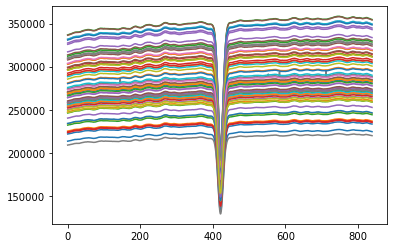

In [39]:
ccfs_summed = ccfs_summed[:-1]
normalization_ccfs = normalization_ccfs[:-1]

ccfs_summed_normalized = ccfs_summed/normalization_ccfs

for c in ccfs_summed_normalized:
    plt.plot(c)
    
# plt.xlim(380, 440)

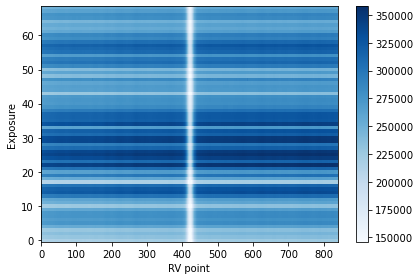

In [40]:
fig = plt.figure()
ax = fig.add_subplot(111)

norm = visualization.ImageNormalize(ccfs_summed_normalized, interval=visualization.ZScaleInterval())
imshow = ax.imshow(ccfs_summed_normalized, norm=norm, origin='lower', aspect='auto', cmap= matplotlib.cm.get_cmap('Blues'), interpolation='none')
ax.set_xlabel('RV point')
ax.set_ylabel('Exposure')
fig.colorbar(imshow)
fig.tight_layout()

# plt.xlim(400, 500)

The slope that we see is an artificial product of the missing color-correction and of the pipeline. We also see some differences in the continua, possibly due to the fact that the planet + Doppler shadow signal is extremely strong in this planet. We thus normalize the CCFs.

## CCF post-processing. What are we seeing?

First, let's calculate at which radial velocity we are expecting the planet. To do that, we need to calculate the planet phases that we are observing, and use the known orbital solution from the literature. We need to take care of the time conversions: the known ephemerid is given in BJD TDB, so we need to convert our exposure times to that same time scale and format. We use astropy for that.

In [41]:
from astropy import time
from astropy.coordinates import SkyCoord, EarthLocation

target_coordinates = SkyCoord.from_name(target_name)
site = EarthLocation.of_site('paranal')

time_observations = []

for hdu in hdus_S2D:
    exp_start=hdu[0].header['MJD-OBS']
    exp_dur=hdu[0].header['EXPTIME']
    time_observations.append(exp_start + exp_dur/(60.*60.*24.))

time_observations=time.Time(np.array(time_observations), format='mjd', scale='utc', location=site)

# We compute the time travel difference to the barycenter of the Solar System
dt_bary = time_observations.light_travel_time(target_coordinates)

# For the barycentric times, which are of our interest, the correct scale is TDB. (https://docs.astropy.org/en/stable/time/index.html#barycentric-and-heliocentric-light-travel-time-corrections).
bjd_time_observations = time_observations.tdb + dt_bary  

In [42]:
T0 =   2457273.4191 # BJD TDB; https://ui.adsabs.harvard.edu/abs/2022ApJS..258...40K/abstract
P_days = 1.8098806
r_AU = 0.0330

phases = ((bjd_time_observations.jd-T0)/P_days)%1
phases = np.where(phases < 0.5, 1+phases, phases) # To have them as a monotic sequence

r_km = r_AU*1.496e8
P_sec = P_days*24.*60.*60.
v_max = 2*np.pi*r_km/P_sec
velocities_spun_during_transit = v_max*np.sin(phases*2.*np.pi)

k_star = 0.1193 # km/s
stellar_phases = 0.5+phases
stellar_velocities = k_star*np.sin(stellar_phases*2.*np.pi)

stellar_velocities

array([ 0.05333288,  0.05174862,  0.05017382,  0.04856668,  0.04694969,
        0.04533777,  0.04370102,  0.04205442,  0.04039382,  0.03874327,
        0.0370699 ,  0.03540639,  0.03371636,  0.03203727,  0.03034847,
        0.02863888,  0.02693413,  0.02520739,  0.02349239,  0.02177089,
        0.02002583,  0.018284  ,  0.01653831,  0.01478878,  0.01305137,
        0.01129261,  0.00953473,  0.0077748 ,  0.00602536,  0.00428706,
        0.0025234 ,  0.00077388, -0.00097271, -0.00272297, -0.00448667,
       -0.00624937, -0.00799028, -0.00973787, -0.01148065, -0.01322479,
       -0.01497691, -0.01672718, -0.0184727 , -0.02020318, -0.02194346,
       -0.02365608, -0.02536981, -0.02709124, -0.02879529, -0.03050527,
       -0.03220811, -0.03388415, -0.03557195, -0.03723616, -0.0388974 ,
       -0.04056134, -0.04220422, -0.04385003, -0.04548616, -0.04710157,
       -0.04871823, -0.05030145, -0.05189777, -0.05348092, -0.0550524 ,
       -0.05660175, -0.05814892, -0.05967378, -0.06118221, -0.06

In [43]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# norm = visualization.ImageNormalize(ccfs_summed/normalization_ccfs, interval=visualization.ZScaleInterval())
# imshow = ax.imshow(ccfs_summed_normalized, norm=norm, origin='lower', aspect='auto', cmap= matplotlib.cm.get_cmap('Blues'), interpolation='none', extent=[np.min(RV_table), np.max(RV_table), np.min(phases), np.max(phases)])
# ax.set_xlabel('RV point')
# ax.set_ylabel('Exposure')
# fig.colorbar(imshow)
# fig.tight_layout()

# plt.plot(velocities_spun_during_transit, phases, 'r')
# plt.plot(velocities_spun_during_transit-5, phases, 'r--')

# # plt.xlim(-20, 10)

In [44]:
# We need to exclude the region where the planet + RML signal come from.

approximate_systemic_velocity = -1.1
vsini = 3.3
max_velocity_during_transit = np.max(abs(velocities_spun_during_transit))

plot_debug = False

i1 = np.searchsorted(RV_table, approximate_systemic_velocity-vsini - 30.)
i2 = np.searchsorted(RV_table, approximate_systemic_velocity-vsini+vsini+30.)

ccfs_summed_normalized_continuum_normalized = []    


for c in ccfs_summed_normalized:

    fit = np.polyfit(np.concatenate((RV_table[:i1], RV_table[i2:])), np.concatenate((c[:i1], c[i2:])),2)
    fit_fn = np.poly1d(fit) 

    if plot_debug:
        import matplotlib.pyplot as plt
        plt.plot(RV_table[i2:], c[i2:], 'k', RV_table[i2:], fit_fn(RV_table[i2:]), 'r')
        plt.plot(np.concatenate((RV_table[:i1], RV_table[i2:])), np.concatenate((c[:i1], c[i2:])), 'k', RV_table, fit_fn(RV_table), 'r')
        plt.show()

    ccfs_summed_normalized_continuum_normalized.append(c/fit_fn(RV_table))

ccfs_summed_normalized_continuum_normalized = np.array(ccfs_summed_normalized_continuum_normalized)

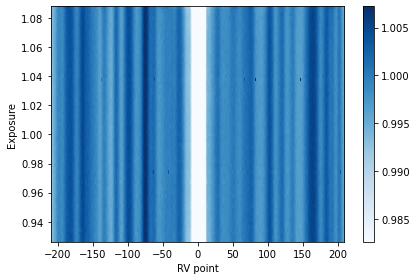

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)

norm = visualization.ImageNormalize(ccfs_summed_normalized_continuum_normalized, interval=visualization.ZScaleInterval())
imshow = ax.imshow(ccfs_summed_normalized_continuum_normalized, norm=norm, origin='lower', aspect='auto', cmap= matplotlib.cm.get_cmap('Blues'), interpolation='none', extent=[np.min(RV_table), np.max(RV_table), np.min(phases), np.max(phases)])
ax.set_xlabel('RV point')
ax.set_ylabel('Exposure')
fig.colorbar(imshow)
fig.tight_layout()

# plt.plot(velocities_spun_during_transit, phases, 'r')
# plt.plot(velocities_spun_during_transit-5, phases, 'r--')
# plt.xlim(-20, 10)

In [46]:
ccfs_summed_normalized_continuum_normalized_star_removed = []
median_ccfs_summed_normalized_continuum_normalized = np.median(ccfs_summed_normalized_continuum_normalized, axis=0)
for s in ccfs_summed_normalized_continuum_normalized:
    ccfs_summed_normalized_continuum_normalized_star_removed.append(s/median_ccfs_summed_normalized_continuum_normalized)
ccfs_summed_normalized_continuum_normalized_star_removed = np.array(ccfs_summed_normalized_continuum_normalized_star_removed)


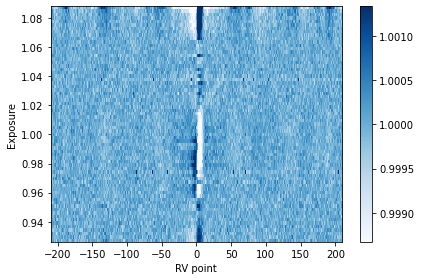

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

norm = visualization.ImageNormalize(ccfs_summed_normalized_continuum_normalized_star_removed, interval=visualization.ZScaleInterval())
imshow = ax.imshow(ccfs_summed_normalized_continuum_normalized_star_removed, norm=norm, origin='lower', aspect='auto', cmap= matplotlib.cm.get_cmap('Blues'), interpolation='none', extent=[np.min(RV_table), np.max(RV_table), np.min(phases), np.max(phases)])
ax.set_xlabel('RV point')
ax.set_ylabel('Exposure')
fig.colorbar(imshow)
fig.tight_layout()
